In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import *

2023-05-10 22:54:01.387840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 22:54:05.989415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
f = open("partial_data.csv", "r")

x = []
y = []

for line in f.readlines():
    sequence = line.split(",")

    sequence = [int(x) for x in sequence]

    for i in range(len(sequence)-10):
        x.append(sequence[i:i+10])
        y.append(sequence[i+10])

f.close()

x = np.array(x)

y = np.array(y)

In [3]:
num = len(y)

idx = np.random.permutation(num)

x = x[idx]
y = y[idx]

x = x.reshape((x.shape[0], x.shape[1], 1))

n_classes = len(np.unique(y))

print(np.unique(y))

print(n_classes)

x_train, y_train, x_val, y_val, x_test, y_test = split_and_shuffle(x, y)

[0 1 2 3 4 5 6 7 8 9]
10


In [4]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [5]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [6]:
input_shape = x.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[256],
    mlp_dropout=0,
    dropout=0.3,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"]
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

results = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    #validation_split=0.2,
    epochs=400,
    batch_size=16,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

2023-05-10 17:31:56.359815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 17:31:56.405775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 17:31:56.406145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 1)       7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

2023-05-10 17:32:06.975992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-10 17:32:07.852996: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3d40a93f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 17:32:07.853032: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-05-10 17:32:07.858153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-10 17:32:08.054007: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 21s 81ms/step - loss: 2.6157 - sparse_categorical_accuracy: 0.1125 - val_loss: 2.4630 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/400
15/15 [==============================] - 0s 24ms/step - loss: 2.1846 - sparse_categorical_accuracy: 0.2042 - val_loss: 2.2940 - val_sparse_categorical_accuracy: 0.0667
Epoch 3/400
15/15 [==============================] - 0s 24ms/step - loss: 1.9728 - sparse_categorical_accuracy: 0.2458 - val_loss: 2.2136 - val_sparse_categorical_accuracy: 0.0333
Epoch 4/400
15/15 [==============================] - 0s 24ms/step - loss: 1.8552 - sparse_categorical_accuracy: 0.2625 - val_loss: 2.1132 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/400
15/15 [==============================] - 0s 25ms/step - loss: 1.7434 - sparse_categorical_accuracy: 0.2917 - val_loss: 2.0332 - val_sparse_categorical_accuracy: 0.0667
Epoch 6/400
15/15 [==============================] - 0s 25ms/step - loss: 1.6614 - sparse_categorical_accuracy:

[0.060432445257902145, 1.0]

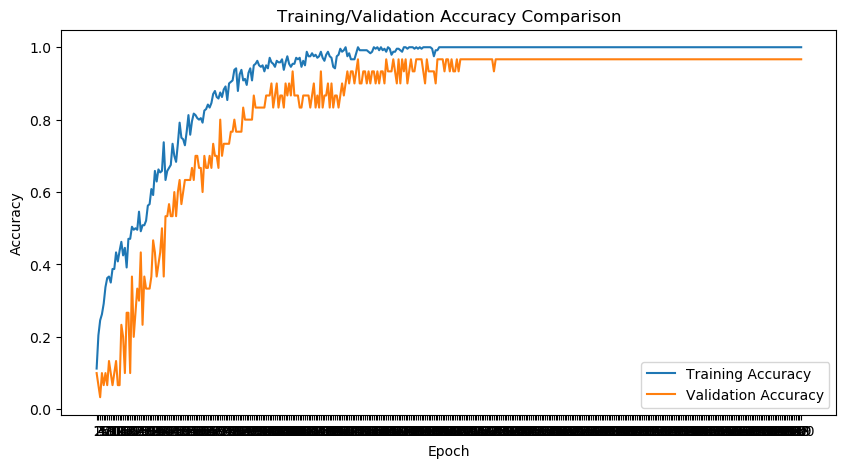

In [7]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

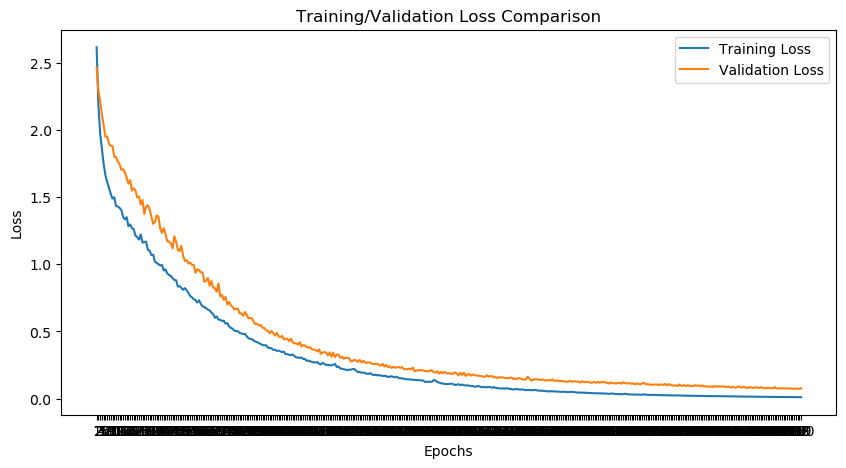

In [8]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

2023-05-10 22:55:38.447243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


1/1 [==============================] - 5s 5s/step


2023-05-10 22:55:40.160813: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


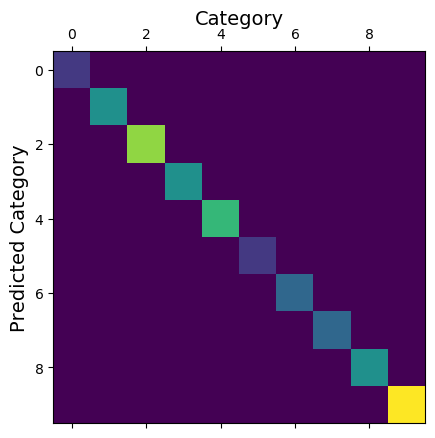

In [6]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
plot_confusion_matrix(y_test, y_pred)

In [9]:
#model.predict(np.array(x[0,:,:]))

In [10]:
#a = np.array([0,1,0,0,1,0,0,1,0,0])
#a = np.array([1,1,0,1,1,0,1,1,0,1])
#a = np.array([2,2,0,2,2,1,2,2,3,2])
a = np.array([7,7,0,7,7,3,7,7,6,7])

a = a.reshape((1, a.shape[0]))

print(a.shape)

model.predict(a)

(1, 10)
1/1 [==============================] - 1s 723ms/step


array([[7.3082526e-30, 4.4471964e-14, 1.9927536e-05, 3.2520634e-21,
        3.7396542e-14, 1.0795863e-08, 1.1314531e-02, 9.7751164e-01,
        1.1152881e-02, 9.3699180e-07]], dtype=float32)

In [14]:
model.save('../models/transformer_numbers')

2023-05-10 17:57:41.004411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,1]
	 [[{{node inputs}}]]
2023-05-10 17:57:41.057204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,4]
	 [[{{node inputs}}]]
2023-05-10 17:57:41.119960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,1]
	 [[{{node inputs}}]]
2023-05-10 17

INFO:tensorflow:Assets written to: ../models/test/assets


INFO:tensorflow:Assets written to: ../models/test/assets


In [5]:
model = tf.keras.models.load_model('../models/transformer_numbers')

2023-05-10 22:55:17.241806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 22:55:17.419390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 22:55:17.420150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
#a = np.array([0,1,0,0,1,0,0,1,0,0])
#a = np.array([1,1,0,1,1,0,1,1,0,1])
#a = np.array([2,2,0,2,2,1,2,2,3,2])
#a = np.array([9,9,0,9,9,1,9,9,3,9])

#a = a.reshape((1, a.shape[0]))

#model.predict(a)